In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import urllib
import matplotlib.pyplot as plt
import cv2
import glob
import os
import time
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Convert the json file to csv and store it because it is easier to work with.
df = pd.read_json("/kaggle/input/vehicle-number-plate-detection/Indian_Number_plates.json", lines=True)
df.to_csv("indian_license_plates.csv", index=False)
new_df=pd.read_csv("/kaggle/working/indian_license_plates.csv")

new_df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [3]:
# This is the data annotation. It contains labels, top and bottom x,y coordinates of the image, image width and image height.
df['annotation'][0]

[{'label': ['number_plate'],
  'notes': '',
  'points': [{'x': 0.722084367245657, 'y': 0.5879828326180251},
   {'x': 0.8684863523573201, 'y': 0.688841201716738}],
  'imageWidth': 806,
  'imageHeight': 466}]

In [4]:
# We will make a new folder/directory 
os.mkdir("Number Plates")

In [5]:
# We will separate image name, Image Width,Image Height,Top X Coordinate, 
# Top Y Coordinate, Bottom x Coordinate, Bootom Y Coordinate
data = dict()
data["img_name"] = list()
data["img_width"] = list()
data["img_height"] = list()
data["top-x"] = list()
data["top-y"] = list()
data["bottom-x"] = list()
data["bottom-y"] = list()

count = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Number Plates/car{}.jpeg".format(count), "JPEG")
    
    data["img_name"].append("car{}".format(count))
    
    d = row["annotation"]
    
    data["img_width"].append(d[0]["imageWidth"])
    data["img_height"].append(d[0]["imageHeight"])
    data["top-x"].append(d[0]["points"][0]["x"])
    data["top-y"].append(d[0]["points"][0]["y"])
    data["bottom-x"].append(d[0]["points"][1]["x"])
    data["bottom-y"].append(d[0]["points"][1]["y"])
    
    count += 1 
    

In [35]:
# We have finished working on the data
new_data=pd.DataFrame(data)
new_data['img_name']=new_data['img_name']+".jpeg"
new_data.head()

,img_name,img_width,img_height,top-x,top-y,bottom-x,bottom-y
0,car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [14]:
# The image width and height are set as 300.
width= 300
height= 300
channels= 3

In [15]:
# View the image
def viewimage(t):
    
    image = cv2.imread("Number Plates/" + new_data["img_name"].iloc[t])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(width,height))
    
    top_x=int(new_data['top-x'].iloc[t]* width)
    top_y=int(new_data['top-y'].iloc[t]*height)
    bot_x=int(new_data['bottom-x'].iloc[t]*height)
    bot_y=int(new_data['bottom-y'].iloc[t]*height)
    
    
    new_img=cv2.rectangle(image,(top_x,top_y),(bot_x,bot_y),(0, 0, 255), 1)
    
    plt.imshow(new_img)
    
    plt.show()

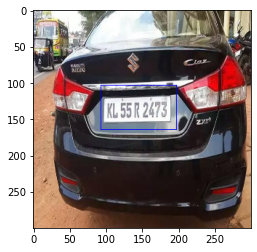

In [16]:
# The x and y coordinates of the label are the bounding box for the license plate.
viewimage(10)

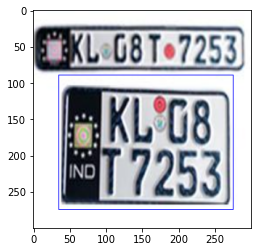

In [17]:
viewimage(100)

In [18]:
# 5 images are dropped from the dataset for testing
n = 5
drop_indices = np.random.choice(new_data.index, n, replace=False)
df_subset = new_data.drop(drop_indices)

In [21]:
# Indices of dropped images.
drop_indices

array([157, 152, 112,  51, 185])

In [23]:
# Loading the data to the model
# The x and y coordinates are the label.
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.05)

train_generator = datagen.flow_from_dataframe(
    df_subset,
    directory="Number Plates/",
    x_col="img_name",
    y_col=["top-x", "top-y", "bottom-x", "bottom-y"],
    target_size=(width,height),
    batch_size=32, 
    class_mode="raw",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df_subset,
    directory="Number Plates/",
    x_col="img_name",
    y_col=["top-x", "top-y", "bottom-x", "bottom-y"],
    target_size=(width,height),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 221 validated image filenames.
Found 11 validated image filenames.


In [28]:
# Pretrained VGG Model is used.
# Using an object detection model instead of image classification can give a slightly better performance
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(width,height,channels)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

58892288/58889256 [==============================] - 3s 0us/step


In [29]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 17,371,636
Trainable params: 2,656,948
Non-trainable params: 14,714,688
__________________________________

In [30]:
# Adam optimizer and mean squared error loss are used
Adam(lr=0.001)
model.compile(optimizer='Adam', loss="mse")

In [31]:
# Train the model for 30 epochs
# The validation loss is just 0.01. Hence, the model performs well
history = model.fit_generator(train_generator,
    steps_per_epoch=7,
    validation_data=validation_generator,
    validation_steps=1,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 8s 1s/step - loss: 0.0652 - val_loss: 0.0837
Epoch 2/30
7/7 [==============================] - 4s 562ms/step - loss: 0.0603 - val_loss: 0.0757
Epoch 3/30
7/7 [==============================] - 4s 591ms/step - loss: 0.0465 - val_loss: 0.0435
Epoch 4/30
7/7 [==============================] - 4s 621ms/step - loss: 0.0295 - val_loss: 0.0323
Epoch 5/30
7/7 [==============================] - 4s 592ms/step - loss: 0.0216 - val_loss: 0.0241
Epoch 6/30
7/7 [==============================] - 4s 583ms/step - loss: 0.0164 - val_loss: 0.0234
Epoch 7/30
7/7 [==============================] - 5s 665ms/step - loss: 0.0143 - val_loss: 0.0226
Epoch 8/30
7/7 [==============================] - 4s 577ms/step - loss: 0.0130 - val_loss: 0.0214
Epoch 9/30
7/7 [==============================] - 4s 580ms/step - loss: 0.0114 - val_loss: 0.0195
Epoch 10/30
7/7 [==============================] - 4s 623ms/step - loss: 0.0107 - val_loss: 0.0186
Epoch 11/30
7/7 [=====

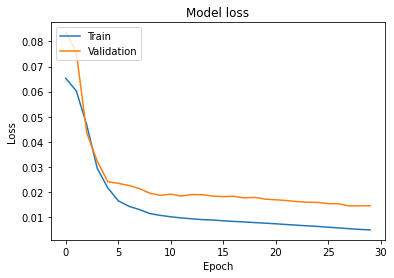

In [32]:
# Plot the train and validation loss over the epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
# Pytesserect(tesseract) is used for reading the license plate
import pytesseract
from PIL import Image

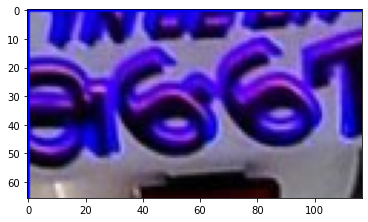

The Car Number is 


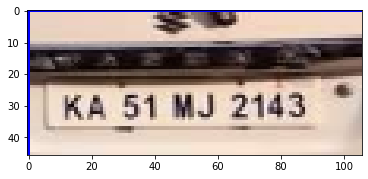

The Car Number is KASIM 2143 ~


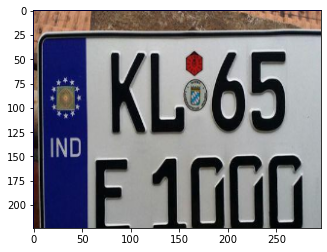

The Car Number is 


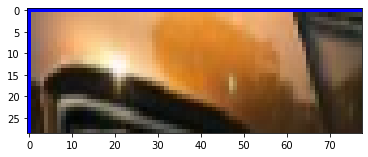

The Car Number is 


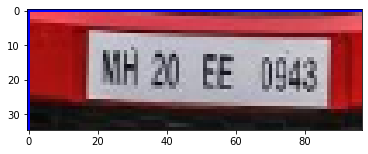

The Car Number is AW 20 E333]


In [46]:
for idx, row in new_data.iloc[drop_indices].iterrows():    
    
    # Resize the image
    img = cv2.resize(cv2.imread("Number Plates/" + row['img_name']) / 255.0, dsize=(width,height))
    
    # Use model to make a prediction
    y_hat = model.predict(img.reshape(1, width,height, 3)).reshape(-1) * width
    
    # Store the top and bottom x,y predictions.
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    # Now we crop the image according to the rectangle predicted.
    img = cv2.cvtColor(img.astype(np.float32),cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0,0,255), 1)
    
    clone = image.copy() 
    crop_img = clone[int(yt):int(yb),int(xt):int(xb)] 
    
    
    # Use pytesseract to make prediction on the text written on the image
    im = Image.fromarray((crop_img * 255).astype(np.uint8))
    car_number = pytesseract.image_to_string(im, lang="eng")
    
    # Print the image and the ocr prediction
    plt.imshow(crop_img)
    plt.show()    
    print("The Car Number is",car_number)
    
    # The prediction is not very accurate. Better model can be built for the ocr task.
    # The image can also be made clearer to improve the model performance.